In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import utils
import torch
from sklearn.model_selection import train_test_split
import pickle
# train svm, lr
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import os
from model import Model

In [2]:
%load_ext autoreload
%autoreload 2

In [46]:
config = utils.read_config()
# set seeds
utils.set_seeds(config['seed'])
behaviour_data_all, spikes, trial_indices = utils.load_dataset(config)
# consider data from only t = -1
# time_from = int(1/bin_len)
# behaviour_data_all, spikes = [x[time_from:, :] for x in behaviour_data_all], [x[time_from:, :] for x in spikes]
stim_idx, choice_idx, amp_idx, prev_choice_idx = 9, 3, 24, 6
stim = [x[0, stim_idx] for x in behaviour_data_all]
choice = [x[0, choice_idx] for x in behaviour_data_all]
prev_choice = [x[0, prev_choice_idx] for x in behaviour_data_all]
amp = torch.tensor([x[:, amp_idx] for x in behaviour_data_all], dtype=torch.float32)
# normalize amp by max value
amp = amp / amp.max()
num_contacts = [np.sum(x[:, 15:19], axis=1) for x in behaviour_data_all]
# concat them
behaviour_data = np.stack((stim, choice, prev_choice), axis=1)
# convert to torch tensors
behaviour_data = np.array(behaviour_data)
# behaviour_data = torch.tensor(behaviour_data, dtype=torch.float32)
spikes = np.array(spikes)
num_trials, time_bins, emissions_dim = spikes.shape
# create dataloader with random sampling for training and testing
# split data into training and testing
# behaviour_data_train, behaviour_data_test, spikes_train, spikes_test = train_test_split(behaviour_data, spikes, test_size=0.3, random_state=42)
behaviour_data_train, behaviour_data_test, spikes_train, spikes_test, num_contacts_train, num_contacts_test = train_test_split(behaviour_data, spikes, num_contacts, test_size=0.2, random_state=7)
# behaviour_data_train, behaviour_data_test, spikes_train, spikes_test, amp_train, amp_test = train_test_split(behaviour_data, spikes, amp, test_size=0.3, random_state=7)
# further split test into test and val
# behaviour_data_test, behaviour_data_val, spikes_test, spikes_val, amp_test, amp_val = train_test_split(behaviour_data_test, spikes_test, amp_test, test_size=0.5, random_state=7)
trials_train, trials_test = len(behaviour_data_train), len(behaviour_data_test)
# distribution of choice and stimulus in test
print("Train distribution of Stimulus: {}, Choice: {}, Prev Choice: {}".format(np.mean(behaviour_data_train[:, 0]), np.mean(behaviour_data_train[:, 1]), np.mean(behaviour_data_train[:, 2])))
print("Test distribution of Stimulus: {}, Choice: {}, Prev Choice: {}".format(np.mean(behaviour_data_test[:, 0]), np.mean(behaviour_data_test[:, 1]), np.mean(behaviour_data_test[:, 2])))
# print("Val distribution of Stimulus: {}, Choice: {}, Prev Choice: {}".format(np.mean(behaviour_data_val[:, 0]), np.mean(behaviour_data_val[:, 1]), np.mean(behaviour_data_val[:, 2])))
# labels
y_stim_train, y_stim_test = behaviour_data_train[:, 0], behaviour_data_test[:, 0]
y_choice_train, y_choice_test = behaviour_data_train[:, 1], behaviour_data_test[:, 1]
y_prev_choice_train, y_prev_choice_test = behaviour_data_train[:, 2], behaviour_data_test[:, 2]

Train distribution of Stimulus: 0.46875, Choice: 0.359375, Prev Choice: 0.453125
Test distribution of Stimulus: 0.5454545454545454, Choice: 0.48484848484848486, Prev Choice: 0.3333333333333333


In [69]:
def reshape(s, c):
    # keep only those time bins where contact is made
    x = []
    for i in range(len(s)):
        x.append(s[i, c[i] > 0])
    return x

train_ = reshape(spikes_train, num_contacts_train)
test_ = reshape(spikes_test, num_contacts_test)
train_acc_stim, test_acc_stim = [], []
train_acc_choice, test_acc_choice = [], []
list_c = [0.1, 1, 2, 5, 10, 20]
# list_c = [10]
# for which_beh, y_train, y_test in [('stim', y_stim_train, y_stim_test), ('choice', y_choice_train, y_choice_test)]:
for which_beh, y_train, y_test in [('stim', y_stim_train, y_stim_test)]:
    # repeat 25 times
    y_train_ = [y_train[i] for i in range(len(train_)) for _ in range(len(train_[i]))]
    y_test_ = [y_test[i] for i in range(len(test_)) for _ in range(len(test_[i]))]
    # stack all spikes and labels
    spikes_train_ = np.vstack(train_)
    spikes_test_ = np.vstack(test_)        
    for c in list_c:
        # train svm
        # clf = SVC(C=c)
        # clf.fit(spikes_train_, y_train_)
        clf = LogisticRegression(penalty='l1', solver='liblinear', C=c)                
        clf.fit(spikes_train_, y_train_)
        # predict
        pred_test = clf.predict(spikes_test_)
        pred_train = clf.predict(spikes_train_)
        # calculate accuracy
        test_accuracy = accuracy_score(y_test_, pred_test)
        train_accuracy = accuracy_score(y_train_, pred_train)
        if which_beh == 'stim':
            train_acc_stim.append(train_accuracy)
            test_acc_stim.append(test_accuracy)            
        else:
            train_acc_choice.append(train_accuracy)
            test_acc_choice.append(test_accuracy)    
# print max test accuracy
max_test_acc_stim = np.max(test_acc_stim)
# max_test_acc_choice = np.max(test_acc_choice)
print("Max test accuracy (stimulus): {}, C = {}".format(max_test_acc_stim, list_c[np.argmax(test_acc_stim)]))
# print("Max test accuracy (choice): {}, C = {}".format(max_test_acc_choice, list_c[np.argmax(test_acc_choice)]))


Max test accuracy (stimulus): 0.6838235294117647, C = 10


In [80]:
# take predictions on entire neural dataset
x0_train = spikes_train.dot(clf.coef_.T) + clf.intercept_
x0_test = spikes_test.dot(clf.coef_.T) + clf.intercept_
x_train = torch.tensor(x0_train, dtype=torch.float32)
x_test = torch.tensor(x0_test, dtype=torch.float32)
behaviour_data_train, behaviour_data_test = torch.tensor(behaviour_data_train, dtype=torch.long), torch.tensor(behaviour_data_test, dtype=torch.long)

/var/folders/d9/5kr9n8rj3t18qph0lvrgf3dw0000gn/T/ipykernel_5544/4292166248.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  behaviour_data_train, behaviour_data_test = torch.tensor(behaviour_data_train, dtype=torch.long), torch.tensor(behaviour_data_test, dtype=torch.long)


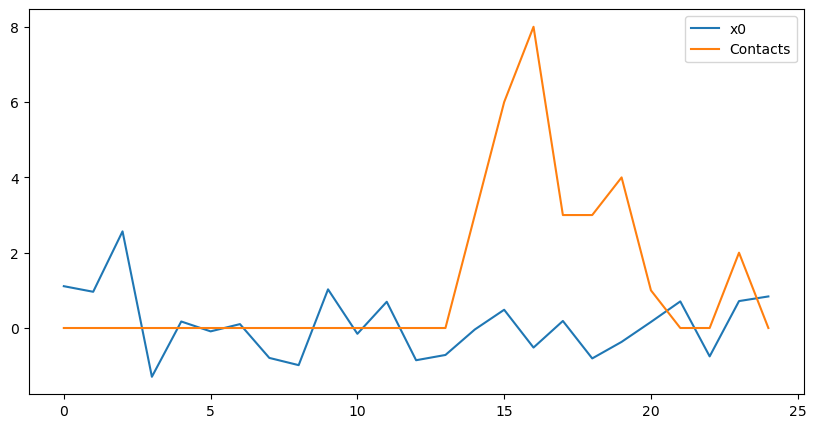

In [78]:
# plot one random trial
trial = np.random.randint(0, len(spikes_test))
plt.figure(figsize=(10, 5))
plt.plot(x0_test[trial], label='x0')
plt.plot(num_contacts_test[trial], label='Contacts')
plt.legend()

In [79]:
# load outputs
pth = "results/dandi_sub-221CR_ses-20190515T160400/100_ms/vae_gp_[1, 1, 1]_diagonal_gru_8_2_True_noise_0.01_rbfscale_0.5_smoothing_3_monotonic_1_1_10_[False, True, False]_3_entropy_None_seed_7/res.pkl"
with open(pth, 'rb') as f:
    outputs = pickle.load(f)
# take z and x
z_train, x_train = outputs[2], outputs[1]
z_test, x_test = outputs[11], outputs[10]
# convert to torch tensors
z_train, x_train = torch.tensor(z_train, dtype=torch.float32), torch.tensor(x_train, dtype=torch.float32)
z_test, x_test = torch.tensor(z_test, dtype=torch.float32), torch.tensor(x_test, dtype=torch.float32)
behaviour_data_train, behaviour_data_test = torch.tensor(behaviour_data_train, dtype=torch.long), torch.tensor(behaviour_data_test, dtype=torch.long)

/var/folders/d9/5kr9n8rj3t18qph0lvrgf3dw0000gn/T/ipykernel_5544/2472723289.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  behaviour_data_train, behaviour_data_test = torch.tensor(behaviour_data_train, dtype=torch.long), torch.tensor(behaviour_data_test, dtype=torch.long)


In [81]:
import decoder
nsamps = config['num_samples_train']
config['decoder']['choice_latent'] = None
config['decoder']['stim_latent'] = 0
# train the linear decoder for behavior
# create linear decoder
decoder_model = decoder.CNNDecoderIndividual(config, [1, 0, 0])
decoder_train_l, decoder_test_l = [], []
# x_train, z_train = torch.tensor(x_train, dtype=torch.float32), torch.tensor(z_train, dtype=torch.float32)
num_epochs = 1000
for epoch in range(num_epochs):    
    # forward pass        
    decoder_model.train()    
    behavior_pred = decoder_model(x_train, z_train)[0]
    # print(behavior_pred)
    # behavior_pred = decoder_model(mu_train[:, :, :2], mu_train[:, :, 2:])    
    loss = decoder_model.loss(behavior_pred, behaviour_data_train, None, None)
    # backward pass
    decoder_model.optimizer.zero_grad()
    loss.backward()
    decoder_model.optimizer.step()
    epoch_loss = loss.item()    
    decoder_train_l.append(epoch_loss)
    # test loss
    if (epoch+1) % 50 == 0:
        decoder_model.eval()
        test_pred = decoder_model(x_test, z_test)[0]
        # behavior_pred = decoder_model(mu_train[:, :, :2], mu_train[:, :, 2:])
        test_loss = decoder_model.loss(test_pred, behaviour_data_test, None, None).item()        
        decoder_test_l.append(test_loss)
        print('Epoch [{}/{}], Train Loss: {:.4f}, Test Loss: {:.4f}'.format(epoch+1, num_epochs, decoder_train_l[-1], decoder_test_l[-1]))

Using stimulus decoder
Scheduler not implemented for decoder
Epoch [50/1000], Train Loss: 9.4999, Test Loss: 9.8974
Epoch [100/1000], Train Loss: 8.6498, Test Loss: 9.9504
Epoch [150/1000], Train Loss: 7.9810, Test Loss: 10.2932
Epoch [200/1000], Train Loss: 7.5596, Test Loss: 10.7433
Epoch [250/1000], Train Loss: 7.3211, Test Loss: 11.3244
Epoch [300/1000], Train Loss: 7.1879, Test Loss: 11.9996
Epoch [350/1000], Train Loss: 7.0679, Test Loss: 12.2724
Epoch [400/1000], Train Loss: 6.9382, Test Loss: 12.5925
Epoch [450/1000], Train Loss: 6.6245, Test Loss: 13.4348
Epoch [500/1000], Train Loss: 6.1417, Test Loss: 14.9296
Epoch [550/1000], Train Loss: 5.5712, Test Loss: 16.7581
Epoch [600/1000], Train Loss: 5.3060, Test Loss: 18.0722
Epoch [650/1000], Train Loss: 5.0428, Test Loss: 18.9200
Epoch [700/1000], Train Loss: 4.8609, Test Loss: 20.2776
Epoch [750/1000], Train Loss: 4.7499, Test Loss: 21.6480
Epoch [800/1000], Train Loss: 4.6753, Test Loss: 22.6994
Epoch [850/1000], Train Loss: 

In [83]:
with torch.no_grad():
    behavior_pred_train = decoder_model(x_train, z_train)[0].detach()
    behavior_pred_test = decoder_model(x_test, z_test)[0].detach()
pred_stim_train = torch.argmax(behavior_pred_train[:, :2], dim=1).numpy()
pred_choice_train = torch.argmax(behavior_pred_train[:, 2:4], dim=1).numpy()     
accuracy_stim = accuracy_score(behaviour_data_train[:, 0], pred_stim_train)        
accuracy_choice = accuracy_score(behaviour_data_train[:, 1], pred_choice_train)
# same for test
pred_stim_test = torch.argmax(behavior_pred_test[:, :2], dim=1).numpy()
pred_choice_test = torch.argmax(behavior_pred_test[:, 2:4], dim=1).numpy()
accuracy_stim_test = accuracy_score(behaviour_data_test[:, 0], pred_stim_test)
accuracy_choice_test = accuracy_score(behaviour_data_test[:, 1], pred_choice_test)
print("Train Accuracy Stim: {}, Choice: {}".format(accuracy_stim, accuracy_choice))
print("Test Accuracy Stim: {}, Choice: {}".format(accuracy_stim_test, accuracy_choice_test))

Train Accuracy Stim: 0.875, Choice: 0.640625
Test Accuracy Stim: 0.5757575757575758, Choice: 0.5151515151515151
